In [4]:
import pandas as pd

pre-process

adding longitude and latitude of the order location

In [ ]:
from geopy.geocoders import Nominatim
import pandas as pd
import time


filtered_df= pd.read_csv('data.csv')

# Create a geolocator object using Nominatim
geolocator = Nominatim(user_agent="CityGeocoderApp")

# Function to get latitude and longitude for a given city
def get_lat_lon(city):
    retries = 3
    for _ in range(retries):
        try:
            location = geolocator.geocode(city)
            if location:
                return location.latitude, location.longitude
            else:
                return None, None
        except Exception as e:
            time.sleep(1)  # Add a short delay before retrying

    return None, None

# Batch processing: Process data in chunks
chunk_size = 100
successful_fetches = 0

for i in range(0, len(filtered_df), chunk_size):
    chunk = filtered_df['Order City'].iloc[i:i+chunk_size]
    
    # Create separate lists for latitude and longitude
    latitudes, longitudes = zip(*chunk.apply(get_lat_lon).tolist())
    
    # Count the successful fetches
    successful_fetches += sum(1 for lat, lon in zip(latitudes, longitudes) if lat is not None and lon is not None)
    
    # Create a DataFrame for the current batch
    batch_filtered_df = pd.DataFrame({'order_latitude': latitudes, 'order_longitude': longitudes})
    
    # Save the current batch to a CSV file
    batch_filtered_df.to_csv(f'batch_{i // chunk_size + 1}_late_delivery.csv', index=False)

# Print the total successful fetches
print(f"Total successful fetches: {successful_fetches}")


creating a tuple with department ids and branches from extracted department excel file 

In [10]:
import csv

def read_csv(file_path):
    places = []

    with open(file_path, 'r') as csv_file:
        csv_reader = csv.reader(csv_file)
        
        # Skip the header row
        next(csv_reader, None)

        for row in csv_reader:
            place_name = row[0].strip()

            for i in range(1, len(row)):
                department_id = f"department id:{i}"
                coordinates_str = row[i].strip()

                if coordinates_str:  # Check if coordinates are not empty
                    coordinates = eval(coordinates_str)  # Convert coordinates string to tuple
                    place_info = (department_id, place_name, coordinates)
                    places.append(place_info)

    return places

def filter_by_department_id(places, department_id):
    filtered_records = []

    for place_info in places:
        if place_info[0] == f"department id:{department_id}":
            location_name = place_info[1]
            coordinates = place_info[2]
            formatted_record = (location_name, coordinates)
            filtered_records.append(formatted_record)

    return filtered_records

# Example usage:
csv_file_path = 'department_coordinates.csv' 
all_places = read_csv(csv_file_path)

# Example: Get records for department id 2
department_id_to_filter = 2
filtered_records = filter_by_department_id(all_places, department_id_to_filter)
places=filtered_records
# for record in filtered_records:
#     print(record)


In [3]:
places = filtered_records
print(places)

[('Caguas', (18.26375771, -66.37055206)), ('San Jose', (37.33831024, -121.9202194)), ('Los Angeles', (34.06435013, -118.437088)), ('Tonawanda', (43.01396942, -78.87906647)), ('Miami', (25.88852501, -80.17294312)), ('San Ramon', (37.77399063, -121.966629)), ('Freeport', (42.82601929, -85.31741333)), ('Salinas', (36.71306229, -121.657959)), ('Peabody', (42.52627564, -70.92703247)), ('Canovanas', (39.49591446, -98.98998261)), ('Paramount', (33.89869309, -118.1745605)), ('Mount Prospect', (42.03620529, -87.96143341)), ('Long Beach', (37.38236237, -122.0837021)), ('Rancho Cordova', (38.60139084, -121.2836609)), ('Billings', (45.78831101, -108.5594101)), ('Wilkes Barre', (41.23545456, -75.86985779)), ('Roseville', (42.4993248, -82.93652344)), ('Bellflower', (34.38807297, -117.4167633)), ('Wheaton', (42.68700028, -87.93047333)), ('Detroit', (42.41725922, -83.15509033)), ('Dallas', (33.05379868, -96.83257294)), ('Carlisle', (40.23770523, -76.96067047)), ('Newark', (40.75481033, -74.1746521)), 

### GA component

Defining variables and required information:
1. zones
2. weight of each category
3. shipping rate

In [1]:
usps_zones = {
    'Zone 1': (1, 50),
    'Zone 2': (51, 150),
    'Zone 3': (151, 300),
    'Zone 4': (301, 600),
    'Zone 5': (601, 1000),
    'Zone 6': (1001, 1400),
    'Zone 7': (1401, 1800),
    'Zone 8': (1801, float('inf')),
    'Zone 9': None  # US territories
}

# Define the dictionary mapping weight to the product category
categories_by_weight = {+
    8: ['Crafts', 'DVDs', 'CDs', 'Books', 'Garden', 'Music'],
    12: ['Sporting Goods','Camping & Hiking', 'Tennis & Racquet', 'Lacrosse', 'Water Sports', 'Indoor/Outdoor Games'],
    1: ['Electronics', 'Cameras', 'Computers', 'Health and Beauty', 'Video Games'],
    2: ['Cleats', "Women's Apparel", "Kids' Golf Clubs", 'Baseball & Softball', 'Soccer', 'Accessories',
        "Girls' Apparel", "Women's Clothing", "Men's Clothing", 'Fitness Accessories', 'Golf Balls', 'Golf Gloves'],
    3: ['Cardio Equipment', "Men's Footwear", 'As Seen on TV!', 'Strength Training', 'Baby', 'Fishing', 'Toys'],
    4: ['Basketball', 'Golf Bags & Carts', "Women's Golf Clubs", "Men's Golf Clubs"],
    5: ['Trade-In', 'Hockey'],
    10: ['Golf Shoes'],
    20: ['Boxing & MMA', 'Consumer Electronics', 'Pet Supplies'],
    40: ['Golf Apparel'],
    60: ['Hunting & Shooting', 'Golf Carts'],
    70: [None]
}

# Define the shipping rates data
shipping_rates_data = {
    'Weight (oz)': [8, 12, 1, 2, 3, 4, 5, 10, 20, 40, 60, 70],
    'Zone 1': [5.40, 6.15, 7.60, 8.50, 8.85, 9.55, 10.20, 12.70, 18.20, 37.65, 46.65, 53.25],
    'Zone 2': [5.50, 6.25, 7.75, 9.00, 9.50, 10.00, 10.65, 13.00, 18.40, 37.70, 46.75, 53.35],
    'Zone 3': [5.55, 6.30, 7.85, 9.55, 9.95, 10.70, 11.40, 13.70, 19.60, 46.75, 55.65, 58.95],
    'Zone 4': [5.60, 6.35, 8.00, 10.25, 10.80, 11.65, 12.45, 15.45, 21.90, 59.70, 70.20, 81.45],
    'Zone 5': [5.65, 6.40, 8.15, 11.00, 11.80, 12.85, 13.75, 18.15, 28.15, 70.90, 92.85, 96.65],
    'Zone 6': [5.70, 6.45, 8.25, 11.80, 12.90, 14.30, 21.55, 21.85, 35.25, 85.25, 109.15, 118.55],
    'Zone 7': [5.75, 6.55, 8.40, 12.90, 16.35, 17.65, 26.25, 26.55, 44.40, 99.25, 124.95, 139.95],
    'Zone 8': [5.85, 6.65, 8.55, 14.90, 17.65, 19.00, 29.35, 31.45, 55.50, 113.65, 141.20, 161.75],
    'Zone 9': [5.85, 6.65, 8.55, 14.90, 17.65, 19.00, 29.35, 31.45, 55.50, 113.65, 141.20, 161.75]
}

open order_csv

In [5]:
order_data=pd.read_csv('late_deliveries.csv')

In [6]:
order_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 59 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     100 non-null    int64  
 1   order_latitude                 100 non-null    float64
 2   order_longitude                100 non-null    float64
 3   Type                           100 non-null    object 
 4   Days for shipping (real)       100 non-null    int64  
 5   Days for shipment (scheduled)  100 non-null    int64  
 6   Benefit per order              100 non-null    float64
 7   Sales per customer             100 non-null    float64
 8   Delivery Status                100 non-null    object 
 9   Late_delivery_risk             100 non-null    int64  
 10  Category Id                    100 non-null    int64  
 11  Category Name                  100 non-null    object 
 12  Department city                100 non-null    obje

In [7]:
order_data=order_data[['Order Item Id','Customer Segment','Order Item Quantity','order_latitude','order_longitude','Product Price','Order Item Discount Rate','Shipping Mode','Department Id','Category Name','Type']]

In [23]:
order_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Order Item Id             100 non-null    int64  
 1   Customer Segment          100 non-null    object 
 2   Order Item Quantity       100 non-null    int64  
 3   order_latitude            100 non-null    float64
 4   order_longitude           100 non-null    float64
 5   Product Price             100 non-null    float64
 6   Order Item Discount Rate  100 non-null    float64
 7   Shipping Mode             100 non-null    object 
 8   Department Id             100 non-null    int64  
 9   Category Name             100 non-null    object 
 10  Type                      100 non-null    object 
dtypes: float64(4), int64(3), object(4)
memory usage: 8.7+ KB


In [19]:
order_data=order_data.head(30)

In [8]:
order_data['Order Item Quantity'] = order_data['Order Item Quantity'] * 100

c:\Users\HP\anaconda3\envs\scarpe_reviews\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\HP\anaconda3\envs\scarpe_reviews\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


11638.74
Order 180517 -
Department ID 2 -
  Best Coordinates: [(40.68665695, -73.37553406)]
  Best Shipping Mode: Standard Class
  Shipping Days: 9

(11638.74, 1.6, 8635.41)
11386.67
Order 179253 -
Department ID 2 -
  Best Coordinates: [(42.29163361, -71.06265259)]
  Best Shipping Mode: Second Class
  Shipping Days: 7

(11386.67, 1.6, 8156.61)
11358.63
Order 179252 -
Department ID 2 -
  Best Coordinates: [(42.52627564, -70.92703247)]
  Best Shipping Mode: Standard Class
  Shipping Days: 1

(11358.63, 1.6, 8635.41)
11616.3
Order 179251 -
Department ID 2 -
  Best Coordinates: [(43.06056595, -78.8788681)]
  Best Shipping Mode: Standard Class
  Shipping Days: 6

(11616.3, 1.6, 8635.41)
11433.42
Order 179250 -
Department ID 2 -
  Best Coordinates: [(47.88882828, -122.2048111)]
  Best Shipping Mode: Standard Class
  Shipping Days: 3

(11433.42, 1.6, 8635.41)
11344.63
Order 179245 -
Department ID 2 -
  Best Coordinates: [(42.77627945, -71.15115356)]
  Best Shipping Mode: Standard Class
  Ship

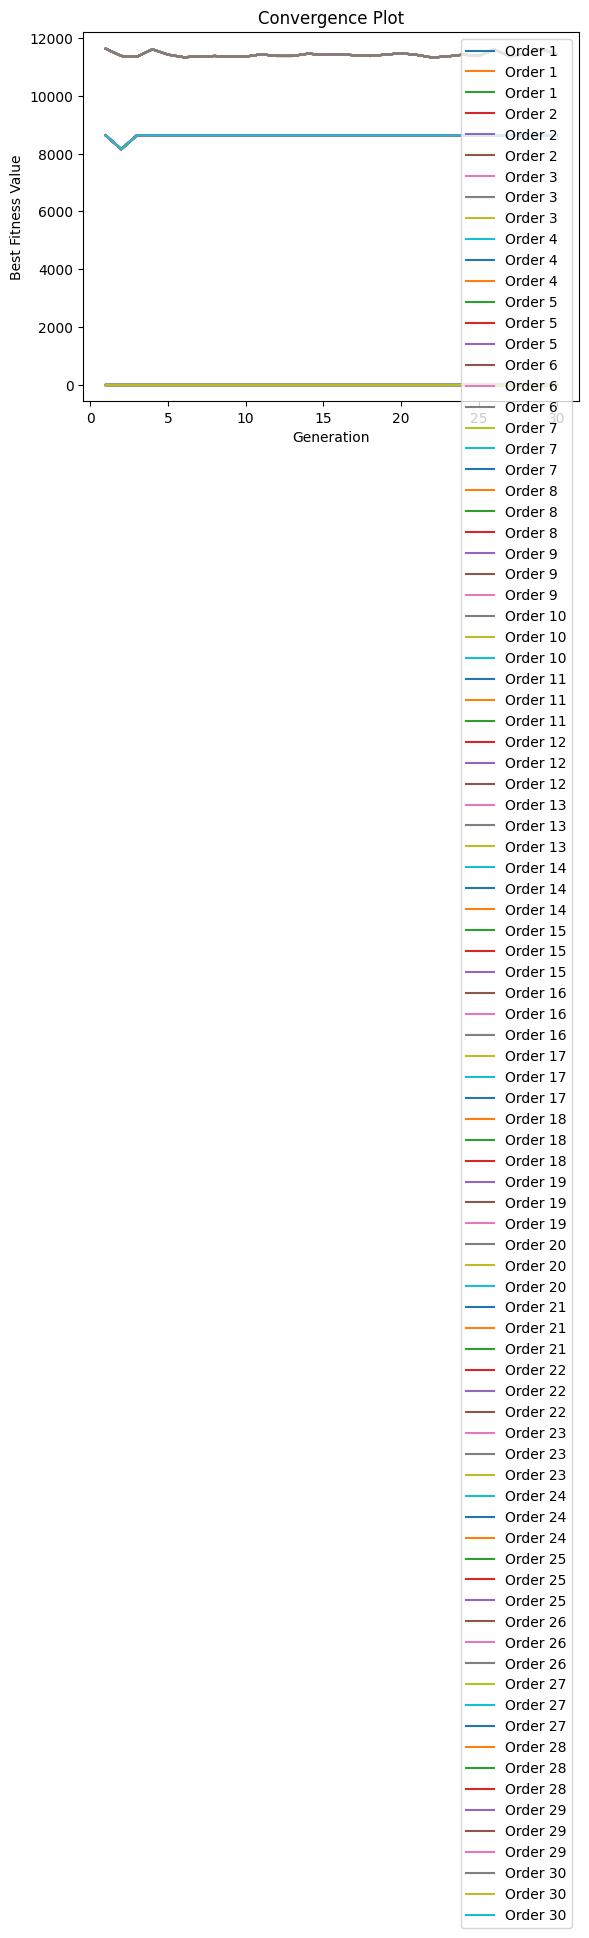

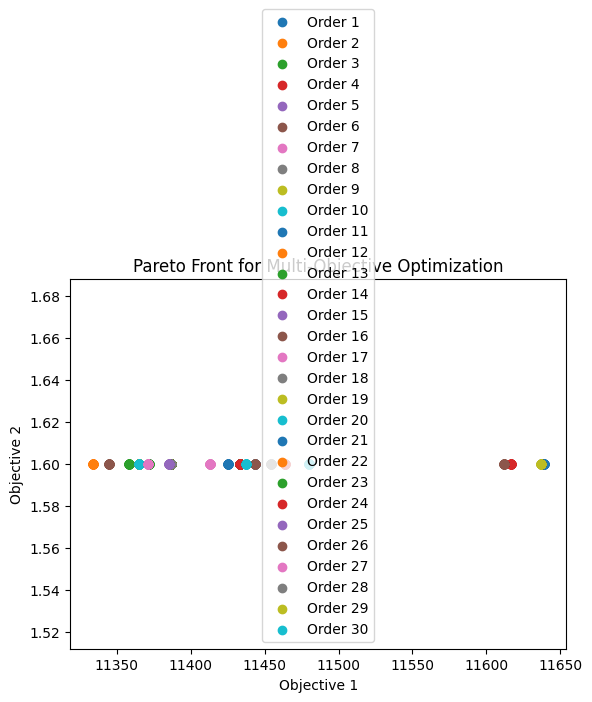

In [23]:
import random
import pandas as pd
from deap import base, creator, tools, algorithms
import mpu as mpu
import matplotlib.pyplot as plt

# Constants for weightages
discount_above_200_weightage = 0.1
discount_below_200_penalty = 0.1
DEBIT_payment_weightage = 0.4
bank_transfer_payment_weightage = 0.6
home_office_weightage = 0.3
corporate_weightage = 0.4
consumer_weightage = 0.3

# Lead time optimization
inventory_threshold = 100
order_volume_increase_percentage = 0.1
DEBIT_payment_lead_time_weightage = 0.6
bank_transfer_payment_lead_time_weightage = 0.4

# Function to shuffle the order of places in an individual
def shuffle_order():
    places_indices = list(range(len(places)))
    random.shuffle(places_indices)
    PlaceIndex = places_indices[0]
    shipping_mode = random.choice(['Standard Class', 'Second Class', 'Same Day'])
    shipping_days = random.randint(1, 10)
    
    return [PlaceIndex,shipping_mode, shipping_days]

# Define DEAP types and fitness function
creator.create("FitnessMulti", base.Fitness, weights=(-1.0,-1.0,+1.0))  # Minimize both distance and cost
creator.create("Individual", list, fitness=creator.FitnessMulti)

# Create a DEAP toolbox
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, shuffle_order)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

def distance_coor(coord1, coord2):
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    return mpu.haversine_distance((lat1, lon1), (lat2, lon2))


def calculate_shipping_mode_cost(shipping_mode):
    cost_map = {'Standard Class': 0.5, 'Second Class': 0.7, 'Same Day': 0.8}
    return cost_map.get(shipping_mode, 1)


def evaluate(individual):

    def calculate_shipping_cost(product_category, best_distance,order_volume,shipping_mode):
        weight_category = next(
            key for key, value in categories_by_weight.items() if product_category in value
        )

        zone = determine_usps_zone(best_distance, usps_zones)
        shipping_rate=shipping_rates_data[zone][shipping_rates_data['Weight (oz)'].index(weight_category)]
        shipping_weightage_mode = calculate_shipping_mode_cost(shipping_mode)
        shipping_cost = order_volume * weight_category * shipping_rate * shipping_weightage_mode
        return shipping_cost

    def determine_usps_zone(best_distance, usps_zones):
        for zone, (lower_bound, upper_bound) in usps_zones.items():
            if upper_bound is None or lower_bound <= best_distance <= upper_bound:
                        return zone
        
    def calculate_shipping_days( best_distance,shipping_days):
        flight_time_hours = best_distance / 500
        shipping_days = int(flight_time_hours / 24)

        return shipping_days
            

    # Iterate over each order
    for i, order in enumerate(order_info_list):
        total_cost, total_profit, total_lead_time = 0, 0, 0
        preparation_time = 1
        # print(f"Processing order {i + 1}")
        # Extract relevant information from the individual array
        place_indices = individual[0]
        shipping_mode = individual[1]
        shipping_days = individual[2]

        place_coords = places[place_indices][1]
        order_coords = (float(order['order_latitude']), float(order['order_longitude']))
        best_distance = round(distance_coor(order_coords, place_coords), 2)
        # print(best_distance)
        order_volume = order['Order Item Quantity']
        product_category=order['Category Name']
        # print(order_volume,product_category)

        shipping_cost = calculate_shipping_cost(str(product_category), best_distance,order_volume,shipping_mode)

        # Consider order volume for lead time optimization
        if order_volume > inventory_threshold:
            preparation_time *= (1 + order_volume_increase_percentage)
        

        # Consider payment method for lead time optimization
        if order['Type'] == 'DEBIT':
            total_lead_time += preparation_time * DEBIT_payment_lead_time_weightage
        else:
            total_lead_time += preparation_time * bank_transfer_payment_lead_time_weightage

        # Discount weightage based on quantity
        if order_volume > 200 and order['Order Item Discount Rate'] > 0:
            discount_weightage = discount_above_200_weightage
        else:
            discount_weightage = -discount_below_200_penalty

        # Payment method weightage
        if order['Type'] == 'DEBIT':
            payment_method_weightage = DEBIT_payment_weightage
        else:
            payment_method_weightage = bank_transfer_payment_weightage

        # Customer segment weightage
        if order['Customer Segment'] == 'Home Office':
            customer_segment_weightage = home_office_weightage
        elif order['Customer Segment'] == 'Corporate':
            customer_segment_weightage = corporate_weightage
        else:
            customer_segment_weightage = consumer_weightage

        # Calculate profit per order
        profit_per_order = (
            (order['Product Price'] * order_volume)
            - (shipping_cost + discount_weightage + payment_method_weightage)
        )  

        total_lead_time+= preparation_time+calculate_shipping_days(best_distance,shipping_days)

        # Apply customer segment weightage
        total_profit += round((profit_per_order * customer_segment_weightage), 2)

        fitness = (best_distance,total_lead_time,total_profit)
    # Return the total distance and total profit for all orders
        # return best_distance, total_profit
        return fitness

# Define the order information as a list of dictionaries
order_info_list = order_data.to_dict(orient='records')

toolbox.register("evaluate", evaluate)
# Number of orders
num_orders = len(order_info_list)

# Number of individuals in the population
population_size = 50

# Number of generations
generations = 100

# Loop through each order, create a population, and perform genetic algorithm
best_fitness_values = []
gen_best_fitness_values=[]
pareto_fronts = []

# best_fitness_values = []
# Loop through each order, create a population, and perform genetic algorithm
for order_index in range(num_orders):

    department_id_to_filter=order_data['Department Id'][order_index]
    places=filter_by_department_id(all_places, department_id_to_filter)

    # Create a population for the current order
    population = toolbox.population(n=population_size)

    # Evaluate the entire population for the current order
    fitness_values = list(map(toolbox.evaluate, population))

    # Assign fitness values to individuals
    for ind, fit in zip(population, fitness_values):
        ind.fitness.values = fit
    
    # Perform genetic algorithm for the current order
    algorithms.eaMuPlusLambda(population, toolbox, mu=population_size, lambda_=2*population_size,
                              cxpb=0.7, mutpb=0.0, ngen=generations, stats=None, halloffame=None,
                              verbose=False)
    
    # Extract Pareto front for the current order
    pareto_front = tools.sortNondominated(population, len(population), first_front_only=True)[0]

    # Find the best individual in the final population
    best_individual = tools.selBest(population, k=1)[0]
    place_index, shipping_mode, shipping_days = best_individual
    
    # Extract fitness values of individuals in the Pareto front
    pareto_front_fitness_values = [ind.fitness.values for ind in pareto_front]
       
       # Store the Pareto front for the current order
    pareto_fronts.append(pareto_front_fitness_values)

    place_index, shipping_mode, shipping_days = best_individual

    coordinates = [(places[int(place_index)][1][0], places[int(place_index)][1][1])]
 
    print(best_individual.fitness.values[0])
    output_message = (
    f"Order {order_data['Order Item Id'][order_index]} -\n"
     f"Department ID {department_id_to_filter} -\n"
    f"  Best Coordinates: {coordinates}\n"
    f"  Best Shipping Mode: {shipping_mode}\n"
    f"  Shipping Days: {shipping_days}\n"
)

    # Print the formatted output
    print(output_message)
  
    gen_best_fitness_values.append(best_individual.fitness.values)

    # Store the best fitness values for the current order
    best_fitness_values.append(gen_best_fitness_values)

    print(best_individual.fitness.values)
min_length = min(len(fit) for fit in best_fitness_values)

for order_index, best_fitness_values_order in enumerate(best_fitness_values):
    trimmed_fitness_values = gen_best_fitness_values[:min_length]
    plt.plot(range(1, len(best_fitness_values_order) + 1), best_fitness_values_order, label=f"Order {order_index + 1}")

plt.xlabel('Generation')
plt.ylabel('Best Fitness Value')
plt.title('Convergence Plot')
plt.legend()
plt.show()


# Plotting the Pareto front for each order
for order_index, pareto_front_fitness_values in enumerate(pareto_fronts):
    # Extract fitness values for each objective
    objective1_values = [fitness[0] for fitness in pareto_front_fitness_values]
    objective2_values = [fitness[1] for fitness in pareto_front_fitness_values]

    # Plot the Pareto front for the current order
    plt.scatter(objective1_values, objective2_values, label=f'Order {order_index + 1}')

plt.xlabel('Objective 1')
plt.ylabel('Objective 2')
plt.title('Pareto Front for Multi-Objective Optimization')
plt.legend()
plt.show()

In [18]:
order_data=order_data[:30]

In [19]:
order_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Order Item Id             30 non-null     int64  
 1   Customer Segment          30 non-null     object 
 2   Order Item Quantity       30 non-null     int64  
 3   order_latitude            30 non-null     float64
 4   order_longitude           30 non-null     float64
 5   Product Price             30 non-null     float64
 6   Order Item Discount Rate  30 non-null     float64
 7   Shipping Mode             30 non-null     object 
 8   Department Id             30 non-null     int64  
 9   Category Name             30 non-null     object 
 10  Type                      30 non-null     object 
dtypes: float64(4), int64(3), object(4)
memory usage: 2.7+ KB


c:\Users\HP\anaconda3\envs\scarpe_reviews\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMulti' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\HP\anaconda3\envs\scarpe_reviews\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


11358.63
Order 180517 -
Department ID 2 -
  Best Coordinates: [(42.52627564, -70.92703247)]
  Best Shipping Mode: Standard Class
  Shipping Days: 2

(11358.63, 3.6, 8635.41)
11358.63
Order 179253 -
Department ID 2 -
  Best Coordinates: [(42.52627564, -70.92703247)]
  Best Shipping Mode: Standard Class
  Shipping Days: 1

(11358.63, 2.6, 8635.41)
11378.45
Order 179252 -
Department ID 2 -
  Best Coordinates: [(42.39771652, -71.10455322)]
  Best Shipping Mode: Standard Class
  Shipping Days: 1

(11378.45, 2.6, 8635.41)
11358.63
Order 179251 -
Department ID 2 -
  Best Coordinates: [(42.52627564, -70.92703247)]
  Best Shipping Mode: Standard Class
  Shipping Days: 1

(11358.63, 2.6, 8635.41)
11437.59
Order 179250 -
Department ID 2 -
  Best Coordinates: [(47.84322357, -122.2460785)]
  Best Shipping Mode: Standard Class
  Shipping Days: 1

(11437.59, 2.6, 8635.41)
11364.85
Order 179245 -
Department ID 2 -
  Best Coordinates: [(42.46523285, -70.93743134)]
  Best Shipping Mode: Second Class
  S

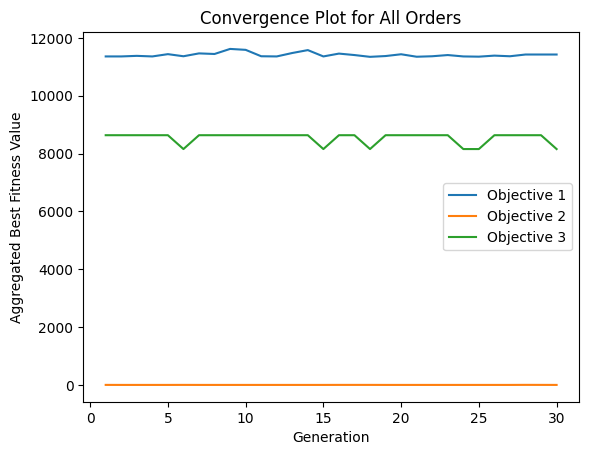

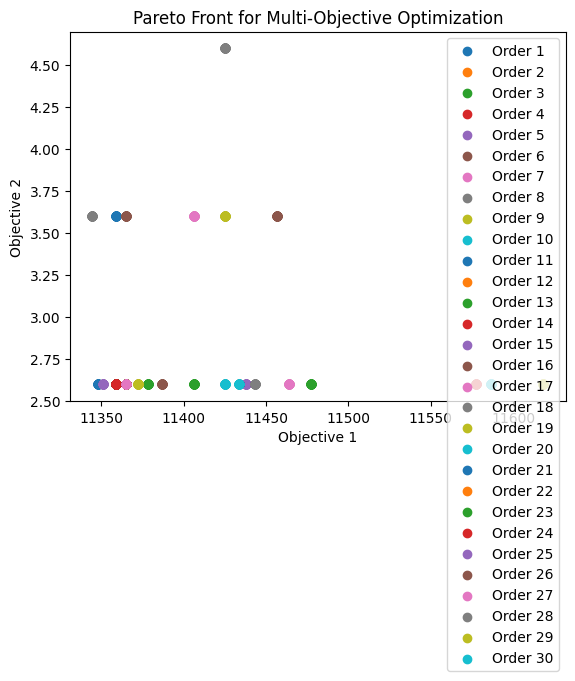

In [37]:
import random
import pandas as pd
from deap import base, creator, tools, algorithms
import mpu as mpu
import matplotlib.pyplot as plt

# Constants for weightages
discount_above_200_weightage = 0.1
discount_below_200_penalty = 0.1
DEBIT_payment_weightage = 0.4
bank_transfer_payment_weightage = 0.6
home_office_weightage = 0.3
corporate_weightage = 0.4
consumer_weightage = 0.3

# Lead time optimization
inventory_threshold = 100
order_volume_increase_percentage = 0.1
DEBIT_payment_lead_time_weightage = 0.6
bank_transfer_payment_lead_time_weightage = 0.4

# Function to shuffle the order of places in an individual
def shuffle_order():
    places_indices = list(range(len(places)))
    random.shuffle(places_indices)
    PlaceIndex = places_indices[0]
    shipping_mode = random.choice(['Standard Class', 'Second Class', 'Same Day'])
    shipping_days = random.randint(1, 10)
    
    return [PlaceIndex,shipping_mode, shipping_days]

# Define DEAP types and fitness function
creator.create("FitnessMulti", base.Fitness, weights=(-1.0,-1.0,+1.0))  # Minimize both distance and cost
creator.create("Individual", list, fitness=creator.FitnessMulti)

# Create a DEAP toolbox
toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, shuffle_order)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

def distance_coor(coord1, coord2):
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    return mpu.haversine_distance((lat1, lon1), (lat2, lon2))


def calculate_shipping_mode_cost(shipping_mode):
    cost_map = {'Standard Class': 0.5, 'Second Class': 0.7, 'Same Day': 0.8}
    return cost_map.get(shipping_mode, 1)


def evaluate(individual):

    def calculate_shipping_cost(product_category, best_distance,order_volume,shipping_mode):
        weight_category = next(
            key for key, value in categories_by_weight.items() if product_category in value
        )

        zone = determine_usps_zone(best_distance, usps_zones)
        shipping_rate=shipping_rates_data[zone][shipping_rates_data['Weight (oz)'].index(weight_category)]
        shipping_weightage_mode = calculate_shipping_mode_cost(shipping_mode)
        shipping_cost = order_volume * weight_category * shipping_rate * shipping_weightage_mode
        return shipping_cost

    def determine_usps_zone(best_distance, usps_zones):
        for zone, (lower_bound, upper_bound) in usps_zones.items():
            if upper_bound is None or lower_bound <= best_distance <= upper_bound:
                        return zone
        
    def calculate_shipping_days( best_distance,shipping_days):
        flight_time_hours = best_distance / 500
        shipping_days = int(flight_time_hours / 24)

        return shipping_days
            

    # Iterate over each order
    for i, order in enumerate(order_info_list):
        total_profit, total_lead_time = 0, 0
        preparation_time = 1
        # print(f"Processing order {i + 1}")
        # Extract relevant information from the individual array
        place_indices = individual[0]
        shipping_mode = individual[1]
        shipping_days = individual[2]

        place_coords = places[place_indices][1]
        order_coords = (float(order['order_latitude']), float(order['order_longitude']))
        best_distance = round(distance_coor(order_coords, place_coords), 2)
        # print(best_distance)
        order_volume = order['Order Item Quantity']
        product_category=order['Category Name']
        # print(order_volume,product_category)

        shipping_cost = calculate_shipping_cost(str(product_category), best_distance,order_volume,shipping_mode)

        # Consider order volume for lead time optimization
        if order_volume > inventory_threshold:
            preparation_time *= (1 + order_volume_increase_percentage)
        

        # Consider payment method for lead time optimization
        if order['Type'] == 'DEBIT':
            total_lead_time += preparation_time * DEBIT_payment_lead_time_weightage
        else:
            total_lead_time += preparation_time * bank_transfer_payment_lead_time_weightage

        # Discount weightage based on quantity
        if order_volume > 200 and order['Order Item Discount Rate'] > 0:
            discount_weightage = discount_above_200_weightage
        else:
            discount_weightage = -discount_below_200_penalty

        # Payment method weightage
        if order['Type'] == 'DEBIT':
            payment_method_weightage = DEBIT_payment_weightage
        else:
            payment_method_weightage = bank_transfer_payment_weightage

        # Customer segment weightage
        if order['Customer Segment'] == 'Home Office':
            customer_segment_weightage = home_office_weightage
        elif order['Customer Segment'] == 'Corporate':
            customer_segment_weightage = corporate_weightage
        else:
            customer_segment_weightage = consumer_weightage

        # Calculate profit per order
        profit_per_order = (
            (order['Product Price'] * order_volume)
            - (shipping_cost + discount_weightage + payment_method_weightage)
        )  
        ship_days=calculate_shipping_days(best_distance,shipping_days)

        total_lead_time+= preparation_time+shipping_days
        # print(f'shipping days chromosome: {shipping_days}')
        # print(f'shipping days: {ship_days}')
        # print(f'preparation_time: {preparation_time}')
        # print(total_lead_time)

        # Apply customer segment weightage
        total_profit += round((profit_per_order * customer_segment_weightage), 2)

        fitness = (best_distance,total_lead_time,total_profit)
    # Return the total distance and total profit for all orders
        # return best_distance, total_profit
        return fitness

# Define the order information as a list of dictionaries
order_info_list = order_data.to_dict(orient='records')

toolbox.register("evaluate", evaluate)
# Number of orders
num_orders = len(order_info_list)

# Number of individuals in the population
population_size = 50

# Number of generations
generations = 100

# Loop through each order, create a population, and perform genetic algorithm
best_fitness_values = []
gen_best_fitness_values=[]
pareto_fronts = []

# best_fitness_values = []
# Loop through each order, create a population, and perform genetic algorithm
for order_index in range(num_orders):

    department_id_to_filter=order_data['Department Id'][order_index]
    places=filter_by_department_id(all_places, department_id_to_filter)

    # Create a population for the current order
    population = toolbox.population(n=population_size)

    # Evaluate the entire population for the current order
    fitness_values = list(map(toolbox.evaluate, population))

    # Assign fitness values to individuals
    for ind, fit in zip(population, fitness_values):
        ind.fitness.values = fit
    
    hall_of_fame = tools.HallOfFame(maxsize=1) 
    # Perform genetic algorithm for the current order
    algorithms.eaMuPlusLambda(population, toolbox, mu=population_size, lambda_=2*population_size,
                              cxpb=0.7, mutpb=0.0, ngen=generations, stats=None, halloffame=hall_of_fame,
                              verbose=False)
    
    # Extract Pareto front for the current order
    pareto_front = tools.sortNondominated(population, len(population), first_front_only=True)[0]

    # Find the best individual in the final population
    best_individual = tools.selBest(population, k=1)[0]
    place_index, shipping_mode, shipping_days = best_individual
    
    # Extract fitness values of individuals in the Pareto front
    pareto_front_fitness_values = [ind.fitness.values for ind in pareto_front]
       
       # Store the Pareto front for the current order
    pareto_fronts.append(pareto_front_fitness_values)

    place_index, shipping_mode, shipping_days = best_individual

    coordinates = [(places[int(place_index)][1][0], places[int(place_index)][1][1])]
 
    print(best_individual.fitness.values[0])
    output_message = (
    f"Order {order_data['Order Item Id'][order_index]} -\n"
     f"Department ID {department_id_to_filter} -\n"
    f"  Best Coordinates: {coordinates}\n"
    f"  Best Shipping Mode: {shipping_mode}\n"
    f"  Shipping Days: {shipping_days}\n"
)

    # Print the formatted output
    print(output_message)
  
    gen_best_fitness_values.append(best_individual.fitness.values)

    # Store the best fitness values for the current order
    best_fitness_values.append(gen_best_fitness_values)

    print(best_individual.fitness.values)
# min_length = min(len(fit) for fit in best_fitness_values)

# for order_index, best_fitness_values_order in enumerate(best_fitness_values):
#     trimmed_fitness_values = gen_best_fitness_values[:min_length]
#     plt.plot(range(1, len(best_fitness_values_order) + 1), best_fitness_values_order, label=f"Order {order_index + 1}")

# plt.xlabel('Generation')
# plt.ylabel('Best Fitness Value')
# plt.title('Convergence Plot')
# plt.legend()
# plt.show()
min_length = min(len(fit) for fit in best_fitness_values)

# Create an array to store the aggregated fitness values across orders
aggregated_fitness_values = []

# Iterate over each generation
for generation in range(1, min_length + 1):
    # Collect best fitness values for the current generation across all orders
    generation_fitness_values = [best_fitness_values_order[generation - 1] for best_fitness_values_order in best_fitness_values]
    
    # Compute the mean or other aggregation metric for the current generation
    aggregated_fitness = tuple(sum(fit_element) / len(fit_element) for fit_element in zip(*generation_fitness_values))
    
    # Append the aggregated fitness value to the array
    aggregated_fitness_values.append(aggregated_fitness)

# Unpack the aggregated fitness values for plotting
aggregated_fitness_values_unpacked = list(zip(*aggregated_fitness_values))

# Plot the aggregated fitness values for all orders
for i, fitness_values in enumerate(aggregated_fitness_values_unpacked):
    plt.plot(range(1, min_length + 1), fitness_values, label=f"Objective {i+1}")

plt.xlabel('Generation')
plt.ylabel('Aggregated Best Fitness Value')
plt.title('Convergence Plot for All Orders')
plt.legend()
plt.show()


# Plotting the Pareto front for each order
for order_index, pareto_front_fitness_values in enumerate(pareto_fronts):
    # Extract fitness values for each objective
    objective1_values = [fitness[0] for fitness in pareto_front_fitness_values]
    objective2_values = [fitness[1] for fitness in pareto_front_fitness_values]

    # Plot the Pareto front for the current order
    plt.scatter(objective1_values, objective2_values, label=f'Order {order_index + 1}')

plt.xlabel('Objective 1')
plt.ylabel('Objective 2')
plt.title('Pareto Front for Multi-Objective Optimization')
plt.legend()
plt.show()

In [24]:
best_fitness_values

[[(11433.42, 5.6, 8635.41),
  (11358.63, 2.6, 8635.41),
  (11407.35, 2.6, 8635.41),
  (11433.42, 2.6, 8635.41),
  (11477.4, 3.6, 8635.41),
  (11453.96, 2.6, 8635.41),
  (11440.41, 2.6, 8635.41),
  (11358.63, 3.6, 8635.41),
  (11433.42, 2.6, 8635.41),
  (11586.5, 2.6, 8635.41),
  (11344.63, 3.6, 8635.41),
  (11614.21, 3.6, 8635.41),
  (11378.45, 2.6, 8635.41),
  (11477.4, 3.6, 8635.41),
  (11358.63, 3.6, 8635.41),
  (11358.63, 2.6, 8635.41),
  (11453.96, 2.6, 8635.41),
  (11371.98, 4.6, 8635.41),
  (11358.63, 2.6, 8635.41),
  (11364.85, 2.6, 8635.41),
  (11440.94, 3.6, 8635.41),
  (11456.68, 2.6, 8635.41),
  (11358.63, 2.6, 8156.61),
  (11642.56, 2.6, 8635.41),
  (11376.45, 2.6, 8635.41),
  (11529.74, 2.6, 8635.41),
  (11364.85, 2.6, 8635.41),
  (11476.41, 4.6, 8635.41),
  (11456.68, 2.6, 8635.41),
  (11348.3, 3.6, 8635.41)],
 [(11433.42, 5.6, 8635.41),
  (11358.63, 2.6, 8635.41),
  (11407.35, 2.6, 8635.41),
  (11433.42, 2.6, 8635.41),
  (11477.4, 3.6, 8635.41),
  (11453.96, 2.6, 8635.4

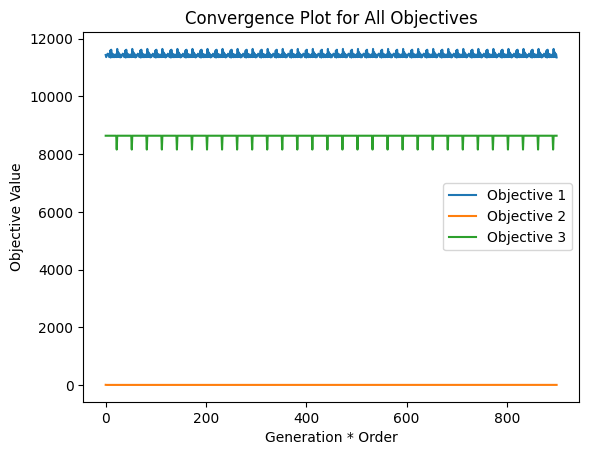

In [31]:
# Assuming best_fitness_values is a list of fitness values for all orders
# Each fitness value is a tuple of (objective1, objective2, objective3)

# Extract each objective separately for all orders
objective1_values = [fit[0] for order_fitness_values in best_fitness_values for fit in order_fitness_values]
objective2_values = [fit[1] for order_fitness_values in best_fitness_values for fit in order_fitness_values]
objective3_values = [fit[2] for order_fitness_values in best_fitness_values for fit in order_fitness_values]

# Plot each objective separately
plt.plot(objective1_values, label="Objective 1")
plt.plot(objective2_values, label="Objective 2")
plt.plot(objective3_values, label="Objective 3")

plt.xlabel('Generation * Order')
plt.ylabel('Objective Value')
plt.title('Convergence Plot for All Objectives')
plt.legend()
plt.show()



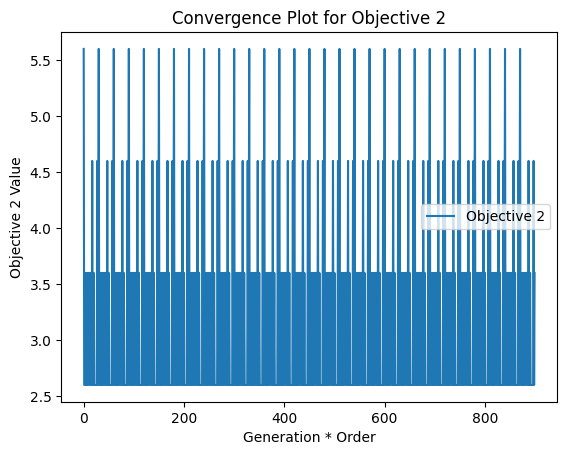

In [30]:
# Assuming best_fitness_values is a list of fitness values for all orders
# Each fitness value is a tuple of (objective1, objective2, objective3)

# Extract Objective 2 values separately for all orders
objective2_values = [fit[1] for order_fitness_values in best_fitness_values for fit in order_fitness_values]

# Plot Objective 2
plt.plot(objective2_values, label="Objective 2")

plt.xlabel('Generation * Order')
plt.ylabel('Objective 2 Value')
plt.title('Convergence Plot for Objective 2')
plt.legend()
plt.show()


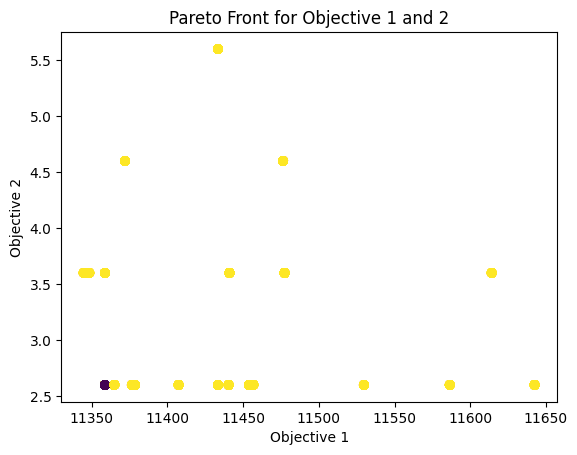

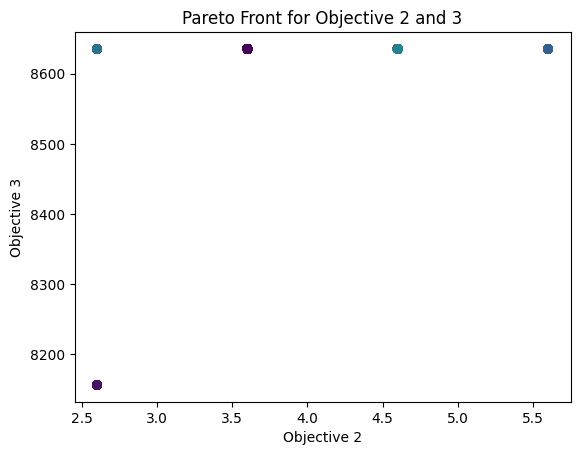

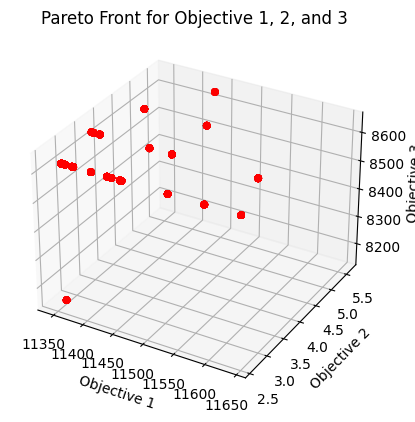

In [32]:
import matplotlib.pyplot as plt
from deap import tools

# Assuming pareto_fronts is a list containing the Pareto fronts for each order
# Each Pareto front is a list of individuals, where each individual is a tuple of (objective1, objective2, objective3)

# Extract Pareto front values separately for all orders
pareto_front_objective1 = [ind[0] for pareto_front in pareto_fronts for ind in pareto_front]
pareto_front_objective2 = [ind[1] for pareto_front in pareto_fronts for ind in pareto_front]
pareto_front_objective3 = [ind[2] for pareto_front in pareto_fronts for ind in pareto_front]

# Plot Pareto front for Objective 1
plt.scatter(pareto_front_objective1, pareto_front_objective2, c=pareto_front_objective3, cmap='viridis')
plt.xlabel('Objective 1')
plt.ylabel('Objective 2')
plt.title('Pareto Front for Objective 1 and 2')
plt.show()

# Plot Pareto front for Objective 2
plt.scatter(pareto_front_objective2, pareto_front_objective3, c=pareto_front_objective1, cmap='viridis')
plt.xlabel('Objective 2')
plt.ylabel('Objective 3')
plt.title('Pareto Front for Objective 2 and 3')
plt.show()

# Plot Pareto front for Objective 1, 2, and 3
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pareto_front_objective1, pareto_front_objective2, pareto_front_objective3, c='r', marker='o')
ax.set_xlabel('Objective 1')
ax.set_ylabel('Objective 2')
ax.set_zlabel('Objective 3')
ax.set_title('Pareto Front for Objective 1, 2, and 3')
plt.show()
